## User Artist Recommendation

The goal of this model is to recommend users new artists based on the type of artists user listened previously. User profiles and artist profiles were created using the spotify tracks datasets. LSH algorithm was used to build a content based recommendation engine. The model was built in PySpark and trained on Apache Spark clusters.


To see more about the LSH alogrithm refer to this https://spark.apache.org/docs/2.2.3/ml-features.html#bucketed-random-projection-for-euclidean-distance

The datasets used are:


*   Spotify Tracks Dataset: https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks
*   List item : https://zenodo.org/record/2594557#.YBNIWOhKhPb

For this specific problem, the artists datasets from the original tracks dataset was used



In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import DenseVector
from pyspark.mllib.linalg.distributed import RowMatrix
# from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import MinMaxScaler
# from pyspark.mllib.linalg import *
import pandas as pd

In [ ]:
# Convert duration from ms -> minutes and remove any outlier
# ----------------------------------------- #
artistdf = ss.read.csv(artistDataPath,header=True,inferSchema=True)
artistdf = artistdf.withColumn('artists',translate('artists', '"','')).withColumn('artists',translate('artists', '”', ''))
artistdf = artistdf.withColumn('duration',col("duration_ms")/60000)
artistdf.show(2, truncate=False)
artistdf.printSchema()

+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+
|artists                       |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|count|duration|
+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+
|Cats 1981 Original London Cast|0.5750833333333334|0.44275           |247260.0   |0.3863358333333334|0.022717396666666667|0.2877083333333333 |-14.205416666666665|0.18067500000000009|115.9835          |0.33443333

In [ ]:
# Convert key feature into a one hot encoeded vector 
ohe = OneHotEncoder()
ohe.setInputCols(["key"])
ohe.setOutputCols(["key_vector"])
model = ohe.fit(artistdf)
artistdf_key_encoded = model.transform(artistdf)
artistdf_key_encoded.show(2, truncate=False)

+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+--------------+
|artists                       |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|count|duration|key_vector    |
+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+--------------+
|Cats 1981 Original London Cast|0.5750833333333334|0.44275           |247260.0   |0.3863358333333334|0.022717396666666667|0.2877083333333333 |-14.205416666666665|0.18

In [ ]:
# Assemble all features into one to create a single vector
audio_feature_columns = ['acousticness', 'danceability', 'energy', 'duration', 'instrumentalness', 'valence', 'popularity',
                                    'tempo', 'liveness', 'loudness', 'speechiness', 'mode', 'count', 'key_vector']
assembler = VectorAssembler(
    inputCols=audio_feature_columns,
    outputCol="features")
artistdf_feature = assembler.transform(artistdf_key_encoded)
artistdf_feature.show(2, truncate=False)

+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+--------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artists                       |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|count|duration|key_vector    |features                                                                                                                                                                                                     

In [ ]:
# Creating artists feature vectos for user profile tags creation (count to be eliminated as feature not present in genres)
audio_feature_columns_id = ['acousticness', 'danceability', 'energy', 'duration', 'instrumentalness', 'valence', 'popularity',
                                    'tempo', 'liveness', 'loudness', 'speechiness', 'mode', 'key_vector']
assembler_id = VectorAssembler(
    inputCols=audio_feature_columns_id,
    outputCol="features")
artistdf_feature_id = assembler_id.transform(artistdf_key_encoded)
artistdf_feature_id.show(2, truncate=False)

+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artists                       |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo             |valence           |popularity       |key|mode|count|duration|key_vector    |features                                                                                                                                                                                                             

In [ ]:
# Scale all features using MinMax scaling method
mmScaler = MinMaxScaler(outputCol="scaled_features")
mmScaler.setInputCol("features")
model = mmScaler.fit(artistdf_feature)
artistdf_scaled = model.transform(artistdf_feature)
artistdf_scaled.show(2, truncate=False)

+------------------------------+------------------+------------------+-----------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+---+----+-----+--------+--------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artists                       |acousticness      |danceability      |duration_ms|energy            |instrumentalness    |liveness           |loudness           |speechiness        |tempo           

In [ ]:
# Scaling the reduced artists features for user id tag as well
mmScaler_id = MinMaxScaler(outputCol="scaled_features")
mmScaler_id.setInputCol("features")
model_id = mmScaler_id.fit(artistdf_feature_id)
artistdf_scaled_id = model_id.transform(artistdf_feature_id)
# artistdf_scaled.show(2, truncate=False)

In [ ]:
# Convert sparse vectors into dense vectors
data_feature_rdd = artistdf_scaled.select(['artists', 'scaled_features']).rdd.map(list)
artistdF_dense = data_feature_rdd.map(lambda kv: (kv[0], DenseVector(kv[1].toArray()))).toDF()
artistdF_dense = artistdF_dense.withColumnRenamed('_1', 'artists').withColumnRenamed('_2', 'scaled_features')
artistdF_dense.printSchema()
artistdF_dense.show(2, truncate=False)

root
 |-- artists: string (nullable = true)
 |-- scaled_features: vector (nullable = true)

+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|artists                       |scaled_features                                                                                                                                                                                                                                                                             |
+------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# COnverting the sparse artists vectors for the user profile id into dense vector as well
data_feature_rdd_id = artistdf_scaled_id.select(['artists', 'scaled_features']).rdd.map(list)
artistdF_dense_id = data_feature_rdd_id.map(lambda kv: (kv[0], DenseVector(kv[1].toArray()))).toDF()
artistdF_dense_id = artistdF_dense_id.withColumnRenamed('_1', 'artists').withColumnRenamed('_2', 'scaled_features')

In [ ]:
# Create Hash Projections
brp = BucketedRandomProjectionLSH(inputCol='scaled_features', outputCol='hashed_projections', seed=123, numHashTables=5, bucketLength=10)
brp_model = brp.fit(artistdF_dense)
artistdF_hashed = brp_model.transform(artistdF_dense)
artistdF_hashed.show(2, truncate=False)

+------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------+
|artists                       |scaled_features                                                                                                                                                                                                                                                                             |hashed_projections                     |
+------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Get the spotify playlist dataset and Check for null values and drop the rows which have null enteries
spotifydf = ss.read.csv(spotifyDataPath,header=True,inferSchema=True)
spotifydf = spotifydf.select('user_id',col(' "artistname"').alias('artistname'), col(' "trackname"').alias("trackname"),col(' "playlistname"').alias('playlistname'))
spotifydf.select([count(when(isnull(c), c)).alias(c) for c in spotifydf.columns]).show()
spotifydf = spotifydf.na.drop()
spotifydf.show(5, truncate=False)

+-------+----------+---------+------------+
|user_id|artistname|trackname|playlistname|
+-------+----------+---------+------------+
|      0|     33562|       82|          45|
+-------+----------+---------+------------+

+--------------------------------+--------------------------------+-----------------------------------------------------+--------------+
|user_id                         |artistname                      |trackname                                            |playlistname  |
+--------------------------------+--------------------------------+-----------------------------------------------------+--------------+
|9cc0cfd4d7d7885102480dd99e7a90d6|Elvis Costello                  |(The Angels Wanna Wear My) Red Shoes                 |HARD ROCK 2010|
|9cc0cfd4d7d7885102480dd99e7a90d6|Elvis Costello & The Attractions|(What's So Funny 'Bout) Peace, Love And Understanding|HARD ROCK 2010|
|9cc0cfd4d7d7885102480dd99e7a90d6|Tiffany Page                    |7 Years Too Late           

In [ ]:
# Join the artist and playlist df
joined_artist_df = spotifydf.join(artistdF_dense, spotifydf.artistname==artistdF_dense.artists)
joined_artist_df.show(5, truncate=False)

+--------------------------------+----------+-------------------+-----------------+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |artistname|trackname          |playlistname     |artists|scaled_features                                                                                                                                                                                                                                                                              |
+--------------------------------+----------+-------------------+-----------------+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Joining the spotify df and the new artist df required for user id tag 
joined_artist_df_id = spotifydf.join(artistdF_dense_id, spotifydf.artistname==artistdF_dense_id.artists)
joined_artist_df_id.show(2, truncate=False)

+--------------------------------+----------+-------------------+------------+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id                         |artistname|trackname          |playlistname|artists|scaled_features                                                                                                                                                                                                                                                         |
+--------------------------------+----------+-------------------+------------+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
print("The total number of observations in the joined df is", joined_artist_df.count())
print("The total number of unique artists in the joined df is", joined_artist_df.select('artistname').distinct().count())
print("The total number of unique users in the joined df is", joined_artist_df.select('user_id').distinct().count())

The total number of observations in the joined df is 8547183
The total number of unique artists in the joined df is 16644
The total number of unique artists in the joined df is 15601


In [ ]:
user_distinct_artist = joined_artist_df.groupby('user_id').agg(countDistinct('artistname').alias('distinct_artist'))

+--------------------------------+---------------+
|user_id                         |distinct_artist|
+--------------------------------+---------------+
|2c0c379f89a3dac1c64e04ef0340b75c|6              |
|1c5ff5dce0c7f6011f748461fea511d7|5              |
|0360dadb07b1f2aaeb15f0f210237302|8              |
|056545ff6bee20986204f331df00328d|10             |
|920cfa37e3ec93e348950670b6195069|6              |
|a69804103a1cc1310f5c3fa9fba5c4ce|1              |
|d88386da3cf26ecc10ba81cf01f39d71|3              |
|a2fe5f2f6c81adf9532a97304b528d7e|2              |
|c816c5059da625c062aee20ed1424de2|6              |
|634286dd46e2a30a807ef140db7f296e|7              |
+--------------------------------+---------------+
only showing top 10 rows



In [ ]:
# Selected a random user and Checking what artists did this user listened to?
# The user can be divided largely into 3 groups based on the distinct number of artists the user listened to: 
#       1) Large Artist Base - (500+)
#       2) Medium Artist Base - (100+)
#       3) Low Artist Base - (10+)
# We will select a random user from each group and test our model
# Finding users from the 3 groups

user_distinct_artist.filter(col('distinct_artist') <= 10).sort(col('distinct_artist').desc()).show(10, truncate=False)
user_distinct_artist.filter(col('distinct_artist') <= 100).sort(col('distinct_artist').desc()).show(10, truncate=False)
user_distinct_artist.filter(col('distinct_artist') <= 500).sort(col('distinct_artist').desc()).show(10, truncate=False)

+--------------------------------+---------------+
|user_id                         |distinct_artist|
+--------------------------------+---------------+
|f2ed2c13b1ee9c9b490b303d700eda9f|500            |
|c126e3612077c80a3dcf496c882533f1|500            |
|478b6343aecfa493c489d7ebdda36b8c|500            |
|1ba47c0c9d49d911e86cc0d666402246|499            |
|376b6b26d087cb19b0a5981b38565b0f|498            |
|91d36e483e6ca77ea5b2b12c13e69bc7|498            |
|20249f8f758d196e0ee5f242697d28be|497            |
|761e82fdf3ae3999f185632a6ef6775c|497            |
|5e288c7e0c059cc56d7ac1646942a39e|497            |
|13e999f0fe9591bcf4f4eea2379b9a61|496            |
+--------------------------------+---------------+
only showing top 10 rows



User 1 -> 1a005fecd058d6383e2db01d06a74743 -> 10 distinct artists

User 2 -> 2b9384c530a562c8b2b931b7a5da9773 -> 100 distinct artists

User 3 -> f2ed2c13b1ee9c9b490b303d700eda9f -> 500 distinct artists

In [ ]:
joined_artist_df.createOrReplaceTempView('joined_artist_table')

# ss.sql("SELECT artistname, COUNT(artistname) FROM joined_artist_table WHERE user_id = 'f2ed2c13b1ee9c9b490b303d700eda9f' GROUP BY artistname ORDER BY COUNT(artistname) DESC").show()
# ss.sql("SELECT user_id, COUNT(DISTINCT artistname) FROM joined_artist_table WHERE COUNT(DISTINCT artistname) <= 10 GROUP BY user_id ORDER BY COUNT(DISTINCT artistname) DESC LIMIT 10").show(truncate=False)
# ss.sql("SELECT user_id, COUNT(DISTINCT artistname) FROM joined_artist_table GROUP BY user_id ORDER BY COUNT(DISTINCT artistname) LIMIT 10").show(truncate=False)

# user_artist_count = ss.sql("SELECT artistname, COUNT(artistname) FROM joined_artist_table WHERE user_id == 'd481556edb513b3d2ea28ed7a68491c4' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 10").collect()
# ss.sql("SELECT COUNT(artistname) FROM joined_artist_table WHERE user_id == 'd481556edb513b3d2ea28ed7a68491c4'").show()

In [ ]:
user_1_artist_count = ss.sql("SELECT artistname, COUNT(artistname) FROM joined_artist_table WHERE user_id = '1a005fecd058d6383e2db01d06a74743' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 10").collect()
user_2_artist_count = ss.sql("SELECT artistname, COUNT(artistname) FROM joined_artist_table WHERE user_id = '2b9384c530a562c8b2b931b7a5da9773' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 10").collect()
user_3_artist_count = ss.sql("SELECT artistname, COUNT(artistname) FROM joined_artist_table WHERE user_id = 'f2ed2c13b1ee9c9b490b303d700eda9f' GROUP BY artistname ORDER BY COUNT(artistname) DESC LIMIT 10").collect()

In [ ]:
# Creating artists profile for the 3 users
joined_artist_rdd = joined_artist_df.rdd.map(list)
joined_artist_rdd.take(2)

[['b5daa64b8ae6b352e5c77f3c4e832181',
  '*NSYNC',
  "Tearin' Up My Heart",
  "Get Movin'",
  '*NSYNC',
  DenseVector([0.1574, 0.6512, 0.7193, 0.0405, 0.0036, 0.6207, 0.4821, 0.5267, 0.2194, 0.8798, 0.0697, 1.0, 0.0243, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])],
 ['ccdbbd7f10743262dcb0081a251ae555',
  '*NSYNC',
  'Bye Bye Bye',
  'Fascinate',
  '*NSYNC',
  DenseVector([0.1574, 0.6512, 0.7193, 0.0405, 0.0036, 0.6207, 0.4821, 0.5267, 0.2194, 0.8798, 0.0697, 1.0, 0.0243, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])]]

In [ ]:
# Creating the artist profile for that user (the profile would be a weighted average)

user_1_artist_profile = joined_artist_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                        .filter(lambda l: l[0] == '1a005fecd058d6383e2db01d06a74743')\
                                        .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                        .map(lambda kv: kv[1][0] / kv[1][1])\
                                        .collect()
user_2_artist_profile = joined_artist_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                        .filter(lambda l: l[0] == '2b9384c530a562c8b2b931b7a5da9773')\
                                        .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                        .map(lambda kv: kv[1][0] / kv[1][1])\
                                        .collect()
user_3_artist_profile = joined_artist_rdd.map(lambda l: (l[0], (l[-1], 1)))\
                                        .filter(lambda l: l[0] == 'f2ed2c13b1ee9c9b490b303d700eda9f')\
                                        .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1]))\
                                        .map(lambda kv: kv[1][0] / kv[1][1])\
                                        .collect()

In [ ]:
# Finding similar artists for the user using the nearest neighbour module of the randomized projection LSH
user_1_artist_neighbours = brp_model.approxNearestNeighbors(artistdF_hashed, user_1_artist_profile[0], 10, distCol='Distance_Measure').collect()
user_2_artist_neighbours = brp_model.approxNearestNeighbors(artistdF_hashed, user_2_artist_profile[0], 10, distCol='Distance_Measure').collect()
user_3_artist_neighbours = brp_model.approxNearestNeighbors(artistdF_hashed, user_3_artist_profile[0], 10, distCol='Distance_Measure').collect()

In [ ]:
user_3_artist_neighbours

[Row(artists='Paula Cole', scaled_features=DenseVector([0.2892, 0.5903, 0.5572, 0.0536, 0.0, 0.6031, 0.5088, 0.5954, 0.1938, 0.8523, 0.0437, 1.0, 0.0035, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), hashed_projections=[DenseVector([-1.0]), DenseVector([0.0]), DenseVector([-1.0]), DenseVector([-1.0]), DenseVector([0.0])], Distance_Measure=0.4062117136992124),
 Row(artists='Industria del Amor', scaled_features=DenseVector([0.2741, 0.5578, 0.5535, 0.0341, 0.0015, 0.6742, 0.4502, 0.5737, 0.2129, 0.8047, 0.039, 1.0, 0.0136, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), hashed_projections=[DenseVector([-1.0]), DenseVector([0.0]), DenseVector([-1.0]), DenseVector([-1.0]), DenseVector([0.0])], Distance_Measure=0.4117210286892202),
 Row(artists='Mick Jagger', scaled_features=DenseVector([0.2139, 0.6504, 0.6872, 0.0476, 0.0274, 0.5641, 0.4649, 0.5663, 0.1203, 0.8349, 0.0736, 1.0, 0.0035, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), hashed_projections=[DenseVect

## Visualizing Results

Dimensionality reduction was performed using principal component analysis (PCA) to visualize results. 3 users were selected at random based on the number of distinct users listened to. The results are as follows

In [ ]:
from pyspark.ml.feature import PCA, PCAModel

In [ ]:
# Map the artists features into 2-D space using PCA to visualize the data and the predictions 
pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
model_pca = pca.fit(artistdF_dense)
artistdF_pca = model_pca.transform(artistdF_dense)
artistdF_pca.show(5, truncate=False)

+-------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------+
|artists                                                      |scaled_features                                                                                                                                                                                                                                                                               |pca_features                             |
+-------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
user_1_recommended_artists = []
user_1_listened_artist = []
for i in user_1_artist_neighbours:
  user_1_recommended_artists.append(i.artists)
for i in user_1_artist_count:
  user_1_listened_artist.append(i.artistname)

In [ ]:
# Top 10 Artists Recommended to the 3 users by the LSH model
user_1_recommended_artists = []
user_1_recommended_artist_x = []
user_1_recommended_artist_y = []

user_2_recommended_artists = []
user_2_recommended_artist_x = []
user_2_recommended_artist_y = []

user_3_recommended_artists = []
user_3_recommended_artist_x = []
user_3_recommended_artist_y = []

for i in user_1_artist_neighbours:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artists).select('pca_features').collect()[0]['pca_features'].toArray()
  user_1_recommended_artists.append((i.artists, coordinate))
  user_1_recommended_artist_x.append(coordinate[0])
  user_1_recommended_artist_y.append(coordinate[1])

for i in user_2_artist_neighbours:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artists).select('pca_features').collect()[0]['pca_features'].toArray()
  user_2_recommended_artists.append((i.artists, coordinate))
  user_2_recommended_artist_x.append(coordinate[0])
  user_2_recommended_artist_y.append(coordinate[1])

for i in user_3_artist_neighbours:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artists).select('pca_features').collect()[0]['pca_features'].toArray()
  user_3_recommended_artists.append((i.artists, coordinate))
  user_3_recommended_artist_x.append(coordinate[0])
  user_3_recommended_artist_y.append(coordinate[1])

user_3_recommended_artists

[('Paula Cole', array([0.28833075, 1.08792407])),
 ('Industria del Amor', array([0.27784009, 1.08861629])),
 ('Mick Jagger', array([0.37492812, 1.10834063])),
 ('Bertie Higgins', array([0.19543854, 1.06369981])),
 ('Frankie Valli', array([0.19542927, 1.0642212 ])),
 ('Collective Soul', array([0.40287414, 1.11724929])),
 ('The Bangles', array([0.39844198, 1.12197635])),
 ('G. Love & Special Sauce', array([0.31005065, 1.09492559])),
 ('Pablo Olivares', array([0.34369542, 1.10048845])),
 ('Mike & The Mechanics', array([0.20691348, 1.06368147]))]

In [ ]:
# The top 10 artists listened by the three users by their count
user_1_listened_artist = []
user_1_listened_artist_x = []
user_1_listened_artist_y = []

user_2_listened_artist = []
user_2_listened_artist_x = []
user_2_listened_artist_y = []

user_3_listened_artist = []
user_3_listened_artist_x = []
user_3_listened_artist_y = []

for i in user_1_artist_count:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_1_listened_artist.append((i.artistname, coordinate))
  user_1_listened_artist_x.append(coordinate[0])
  user_1_listened_artist_y.append(coordinate[1])

for i in user_2_artist_count:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_2_listened_artist.append((i.artistname, coordinate))
  user_2_listened_artist_x.append(coordinate[0])
  user_2_listened_artist_y.append(coordinate[1])

for i in user_3_artist_count:
  coordinate = artistdF_pca.filter(artistdF_pca.artists == i.artistname).select('pca_features').collect()[0]['pca_features'].toArray()
  user_3_listened_artist.append((i.artistname, coordinate))
  user_3_listened_artist_x.append(coordinate[0])
  user_3_listened_artist_y.append(coordinate[1])

user_3_listened_artist

[('Madonna', array([0.35130136, 1.16235194])),
 ('Prince', array([0.3824037 , 1.11730787])),
 ('Wendy & Lisa', array([0.57298959, 1.13042296])),
 ('Panic! At The Disco', array([0.51454401, 1.11426418])),
 ('Diana Ross', array([0.16557685, 0.97995219])),
 ('Cobra Starship', array([0.88403589, 0.52172799])),
 ('Fall Out Boy', array([0.59548681, 1.19064875])),
 ('Janet Jackson', array([0.43552875, 1.13067254])),
 ('Fleetwood Mac', array([0.16829149, 1.01558118])),
 ('My Chemical Romance', array([0.46825868, 1.14498418]))]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

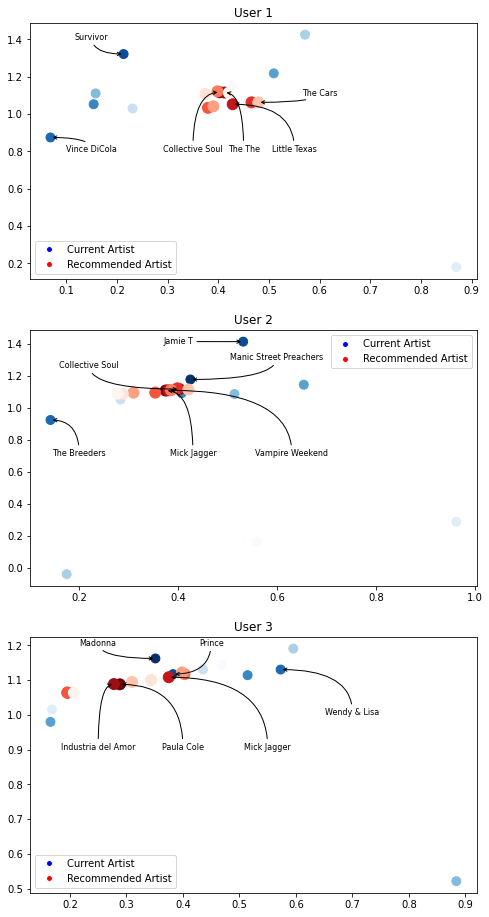

In [ ]:
fig = plt.figure(figsize=(8,16))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

priority_list = [10,9,8,7,6,5,4,3,2,1]

legend_elements = [Line2D([0], [0], color='w', marker='o', markerfacecolor='b', label='Current Artist'),
                   Line2D([0], [0], color='w', marker='o', markerfacecolor='r', label='Recommended Artist'),
                   ]

ax1.scatter(user_1_listened_artist_x, user_1_listened_artist_y, s=80, c=priority_list, cmap='Blues', marker="o", edgecolors='face')
ax1.scatter(user_1_recommended_artist_x, user_1_recommended_artist_y,  s=120, c=priority_list, cmap='Reds', marker="o", edgecolors='face')

ax2.scatter(user_2_listened_artist_x, user_2_listened_artist_y, s=80, c=priority_list, cmap='Blues', marker="o", edgecolors='face')
ax2.scatter(user_2_recommended_artist_x, user_2_recommended_artist_y, s=120, c=priority_list, cmap='Reds', marker="o", edgecolors='face')

ax3.scatter(user_3_listened_artist_x, user_3_listened_artist_y, s=80, c=priority_list, cmap='Blues', marker="o", edgecolors='face')
ax3.scatter(user_3_recommended_artist_x, user_3_recommended_artist_y, s=120, c=priority_list, cmap='Reds', marker="o", edgecolors='face')

for i in user_1_listened_artist:
  if i[0] == 'The Cars':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.6, 1.1), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Survivor':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.15, 1.4), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Vince DiCola':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.15, 0.8), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")

for i in user_1_recommended_artists:
  if i[0] == 'The The':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.45, 0.8), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Collective Soul':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.35, 0.8), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Little Texas':
    ax1.annotate(i[0], (i[1][0],i[1][1]), (0.55, 0.8), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
    
for i in user_2_listened_artist:
  if i[0] == 'Manic Street Preachers':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.6, 1.3), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Jamie T':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.4, 1.4), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'The Breeders':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.2, 0.7), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")

for i in user_2_recommended_artists:
  if i[0] == 'Mick Jagger':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.43, 0.7), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Collective Soul':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.22, 1.25), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
  if i[0] == 'Vampire Weekend':
    ax2.annotate(i[0], (i[1][0],i[1][1]), (0.63, 0.7), 'data', \
                  arrowprops=dict(arrowstyle="->", \
                  connectionstyle="angle3", lw=1), \
                  size=8, ha="center")
    
for i in user_3_listened_artist:
 
  if ((0.35 < i[1][0] < 0.45) and (1.1 < i[1][1] < 1.2)):
    if i[0] == "Madonna":
      ax3.annotate(i[0], (i[1][0],i[1][1]), (0.25, 1.2), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
    if i[0] == "Prince":
      ax3.annotate(i[0], (i[1][0],i[1][1]), (0.45, 1.2), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
  if i[0] == 'Wendy & Lisa':
      ax3.annotate(i[0], (i[1][0],i[1][1]), (0.7, 1), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
      
for i in user_3_recommended_artists:
  if i[0] == 'Paula Cole':
    ax3.annotate(i[0], (i[1][0],i[1][1]), (0.4, 0.9), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
  if i[0] == 'Industria del Amor':
    ax3.annotate(i[0], (i[1][0],i[1][1]), (0.25, 0.9), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
  if i[0] == 'Mick Jagger':
    ax3.annotate(i[0], (i[1][0],i[1][1]), (0.55, 0.9), 'data', \
                arrowprops=dict(arrowstyle="->", \
                connectionstyle="angle3", lw=1), \
                size=8, ha="center")
    
ax1.set_title('User 1')
ax2.set_title('User 2')
ax3.set_title('User 3')

ax1.legend(handles=legend_elements, loc='lower left')
ax2.legend(handles=legend_elements, loc='upper right')
ax3.legend(handles=legend_elements, loc='lower left')

plt.show()

## Validating Results

Cosine similarity was selected as an measure to validate the recommendations obtained by the model. The results indicate the model was efficient in handling the task and provides quality recommendations

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Cosine Similarity for user 1 
user_1_top_3_listened = []
user_1_top_3_r = []

for i in user_1_listened_artist[0:3]:
  user_1_top_3_listened.append(i)
for i in user_1_recommended_artists[0:3]:
  user_1_top_3_r.append(i)

user_1_top_3_l_pd = artistdF_dense.filter((col('artists') == user_1_top_3_listened[0]) | (col('artists') == user_1_top_3_listened[1]) | (col('artists') == user_1_top_3_listened[2])).collect()
user_1_top_3_r_pd = artistdF_dense.filter((col('artists') == user_1_top_3_r[0]) | (col('artists') == user_1_top_3_r[1]) | (col('artists') == user_1_top_3_r[2])).collect()

user_1_listened_array = np.array([user_1_top_3_l_pd[0].scaled_features.toArray(), user_1_top_3_l_pd[1].scaled_features.toArray(),  user_1_top_3_l_pd[2].scaled_features.toArray()])
user_1_recommended_array = np.array([user_1_top_3_r_pd[0].scaled_features.toArray(), user_1_top_3_r_pd[1].scaled_features.toArray(), user_1_top_3_r_pd[2].scaled_features.toArray()])

In [ ]:
user_1_similarity_matrix = cosine_similarity(user_1_listened_array, user_1_recommended_array)
user_1_similarity_matrix

array([[0.87368485, 0.77622551, 0.86828202],
       [0.8841403 , 0.99744603, 0.8866511 ],
       [0.78794648, 0.68279092, 0.79785186]])

In [ ]:
# Cosine Similarity for User 2

user_2_top_3_listened = []
user_2_top_3_r = []

for i in user_2_listened_artist[0:3]:
  user_2_top_3_listened.append(i[0])
for i in user_2_recommended_artists[0:3]:
  user_2_top_3_r.append(i[0])

user_2_top_3_l_pd = artistdF_dense.filter((col('artists') == user_2_top_3_listened[0]) | (col('artists') == user_2_top_3_listened[1]) |  (col('artists') == user_2_top_3_listened[2])).collect()
user_2_top_3_r_pd = artistdF_dense.filter((col('artists') == user_2_top_3_r[0]) | (col('artists') == user_2_top_3_r[1]) | (col('artists') == user_2_top_3_r[2])).collect()

user_2_listened_array = np.array([user_2_top_3_l_pd[0].scaled_features.toArray(), user_2_top_3_l_pd[1].scaled_features.toArray(), user_2_top_3_l_pd[2].scaled_features.toArray()])
user_2_recommended_array = np.array([user_2_top_3_r_pd[0].scaled_features.toArray(), user_2_top_3_r_pd[1].scaled_features.toArray(), user_2_top_3_r_pd[2].scaled_features.toArray()])

In [ ]:
user_2_similarity_matrix = cosine_similarity(user_2_listened_array, user_2_recommended_array)
user_2_similarity_matrix

array([[0.88330285, 0.88221803, 0.87639688],
       [0.8393588 , 0.83497989, 0.8238842 ],
       [0.8277222 , 0.82418499, 0.8279867 ]])

In [ ]:
# Cosine Similarity for User 3

user_3_top_3_listened = []
user_3_top_3_r = []

for i in user_3_listened_artist[0:3]:
  user_3_top_3_listened.append(i[0])
for i in user_3_recommended_artists[0:3]:
  user_3_top_3_r.append(i[0])

user_3_top_3_l_pd = artistdF_dense.filter((col('artists') == user_3_top_3_listened[0]) | (col('artists') == user_3_top_3_listened[1]) |  (col('artists') == user_3_top_3_listened[2])).collect()
user_3_top_3_r_pd = artistdF_dense.filter((col('artists') == user_3_top_3_r[0]) | (col('artists') == user_3_top_3_r[1]) | (col('artists') == user_3_top_3_r[2])).collect()

user_3_listened_array = np.array([user_3_top_3_l_pd[0].scaled_features.toArray(), user_3_top_3_l_pd[1].scaled_features.toArray(), user_3_top_3_l_pd[2].scaled_features.toArray()])
user_3_recommended_array = np.array([user_3_top_3_r_pd[0].scaled_features.toArray(), user_3_top_3_r_pd[1].scaled_features.toArray(), user_3_top_3_r_pd[2].scaled_features.toArray()])

In [ ]:
user_3_similarity_matrix = cosine_similarity(user_3_listened_array, user_3_recommended_array)
user_3_similarity_matrix

array([[0.88004155, 0.88390298, 0.88055047],
       [0.87376614, 0.87301854, 0.8731053 ],
       [0.87155825, 0.8749894 , 0.86486928]])